In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

# Wczytywanie danych

### Ceny

Ceny z https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rynkowa-cena-energii-elektrycznej-rce.
Okres: 2024-02-20 - 2024-03-21, krok - 1 godzina.

In [380]:
prices = pd.read_csv("data\\prices\\ceny_mar.csv", delimiter=';', decimal=',')

In [381]:
prices.Godzina = prices.Godzina - 1  # dodawać 1 dzień do daty
prices['dt'] = prices.Data * 100 + prices.Godzina
prices.dt = pd.to_datetime(prices.dt, format='%Y%m%d%H')
prices = prices.drop(columns=['Data', 'Godzina'])
prices.RCE = prices.RCE / 1000

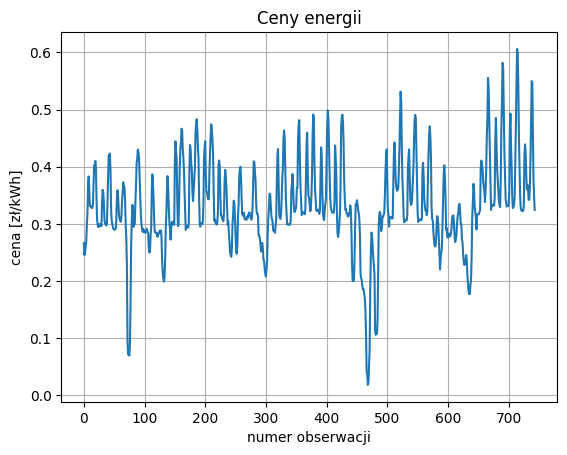

In [382]:
_ = prices.RCE.plot(grid=True, xlabel='numer obserwacji', ylabel='cena [zł/kWh]', title='Ceny energii')

### Energia

Dane z solcast.com dla Wrocławia. Okres: 2024-02-20 - 2024-03-21, krok - 1 godzina.

GHI - całkowite natężenie promieniowania słonecznego na poziomej powierzchni Ziemi. Jest to suma bezpośredniego napromieniowania (po uwzględnieniu kąta zenitalnego Słońca z) i rozproszonego poziomego napromieniowania

In [383]:
ghi = pd.read_csv('data\\solar_stuff\\solar_short.csv', usecols=['ghi', 'period_end'])
ghi.period_end = pd.to_datetime(ghi.period_end)

In [384]:
ghi = ghi[(ghi.period_end >= "20/02/2024") & (ghi.period_end <= "21/03/2024")]
ghi = ghi.reset_index()
ghi.ghi = ghi.ghi / 1000

In [385]:
ghi

,index,ghi,period_end
0,9959,0.0,2024-02-20 00:00:00+00:00
1,9960,0.0,2024-02-20 01:00:00+00:00
2,9961,0.0,2024-02-20 02:00:00+00:00
3,9962,0.0,2024-02-20 03:00:00+00:00
4,9963,0.0,2024-02-20 04:00:00+00:00
...,...,...,...
716,10675,0.0,2024-03-20 20:00:00+00:00
717,10676,0.0,2024-03-20 21:00:00+00:00
718,10677,0.0,2024-03-20 22:00:00+00:00
719,10678,0.0,2024-03-20 23:00:00+00:00


# Dobór funkcji

### Ceny

In [386]:
prices_train = prices[prices.dt < '2024-03-11']

In [387]:
def _price_func(x, a, b, c, d, e, f, g):
    return a * np.sin(b * (2 * np.pi) * x + c) + \
        d * np.sin(2 * np.pi * e * x + f) + g

In [388]:
price_params = scipy.optimize.curve_fit(_price_func, prices_train.index, prices_train.RCE,
                                        p0=[prices_train.std().iloc[0],
                                            1 / (7 * 24),
                                            1,
                                            prices_train.std().iloc[0],
                                            1 / 24,
                                            1,
                                            prices_train.mean().iloc[0]])

In [389]:
price_params[0]

array([ 0.05091857,  0.00520162,  1.78214237, -0.04121694,  0.04115892,
        0.89502662,  0.32510952])

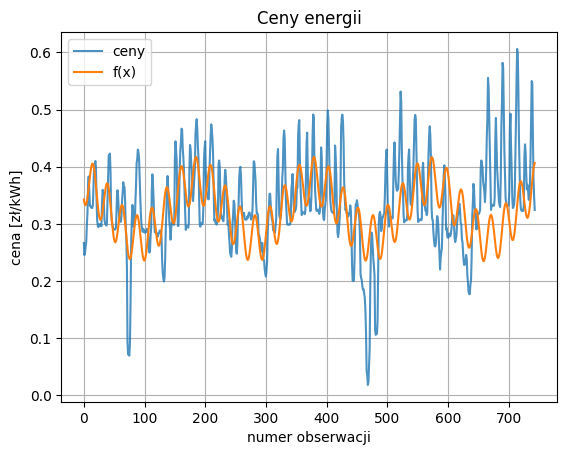

In [392]:
_ = prices.RCE.plot(grid=True, xlabel='numer obserwacji', ylabel='cena [zł/kWh]', title='Ceny energii', alpha=0.8)
_ = plt.plot(prices.index, _price_func(prices.index, *price_params[0]), c='C1', alpha=1)
_ = plt.legend(['ceny', 'f(x)'])

In [393]:
print('{}sin(2pi{}x + {}) + {}sin(2pi{}x + {}) + {}'.
               format(*[np.round(param, 3) for param in price_params[0]]))

0.051sin(2pi0.005x + 1.782) + -0.041sin(2pi0.041x + 0.895) + 0.325


In [394]:
price_func = lambda x: _price_func(x, *price_params[0])

### Energia

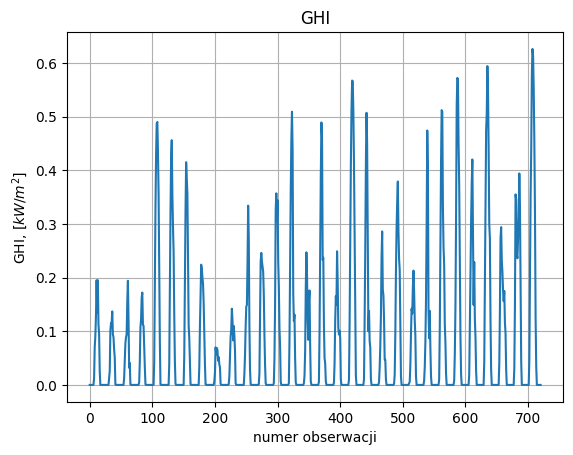

In [396]:
_ = ghi.ghi.plot(title="GHI", grid=True, xlabel="numer obserwacji", ylabel="GHI, [$kW/m^2$]")

In [397]:
area = 1 * 1.65
efficiency = 0.2
ghi["energy"] = ghi.ghi * area * efficiency

In [398]:
def _energy_func(x, a, b, c):
    temp = a * np.sin(2 * np.pi * b * x + c)
    return [t if t > 0 else 0 for t in temp]

In [399]:
energy_params = scipy.optimize.curve_fit(_energy_func, ghi.index, ghi.energy,
                                         p0=[ghi.energy.std(),
                                             1 / 24,
                                             1])

In [400]:
energy_params[0]

array([ 0.09331563,  0.04168122, -1.43877234])

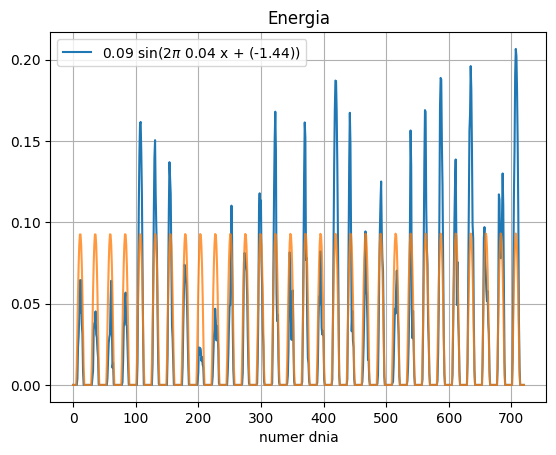

In [404]:
_ = ghi.energy.plot(title="Energia", xlabel="numer dnia", grid=True)
_ = plt.plot(ghi.index, _energy_func(ghi.index, *energy_params[0]), c='C1', alpha=0.8)
_ = plt.legend(['{} sin(2$\pi$ {} x + ({}))'.
               format(*[np.round(param, 2) for param in energy_params[0]])])

In [405]:
energy_func = lambda x: _energy_func(x, *energy_params[0])

### Zapotrzebowanie

In [406]:
def demand(t, annual_demand=50):  # zapotrzebowanie w MWh
    return annual_demand / 365

In [407]:
def ste_demand(t, dates, annual_demand=50):
    daily = annual_demand / 250
    pass

# Ograniczenia

In [182]:
annual_demand = 0  #[MWh]

In [310]:
Rc = 1000  # the energy capacity in kWh
nc = 0.8  # the charging efficiency of the device
nd = 0.8  # the discharging efficiency of the device
gc = Rc / 5  # the max charging rate of the device [MWh per hour]
gd = Rc / 5  # the max discharging rate of the device [MWh per hour]
ch = 1  # the holding cost of the device [$ per MWh per time step]

In [311]:
Rc

200

# Zmienne i stan

In [312]:
dates = prices[prices.dt >= '2024-03-11'].dt.reset_index(drop=True)
t = np.arange(len(dates))

S = pd.DataFrame({"P": price_func(t),
                  "D": demand(t, annual_demand),
                  "E": energy_func(t),
                  "R": np.zeros(len(dates))})

phi = np.array([0, 0, -1, nc, nc, -1])

In [313]:
S

,P,D,E,R
0,342.736607,0.0,0.0,0.0
1,336.837196,0.0,0.0,0.0
2,333.391139,0.0,0.0,0.0
3,332.599590,0.0,0.0,0.0
4,334.483734,0.0,0.0,0.0
...,...,...,...,...
259,326.790030,0.0,0.0,0.0
260,320.960067,0.0,0.0,0.0
261,312.892063,0.0,0.0,0.0
262,303.052479,0.0,0.0,0.0


# Rozwiązanie

In [410]:
from solver import solve

In [411]:
xs = solve(S, Rc, nc, nd, gc, gd)

In [413]:
S.R = xs.dot(phi).cumsum()

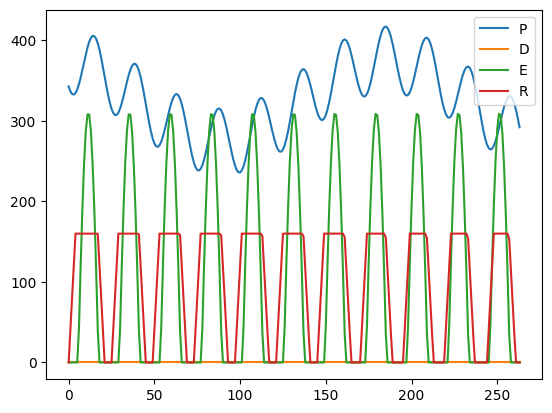

In [415]:
_ = S.plot()